<a href="https://colab.research.google.com/github/lugsantistebanji/WCS-IA/blob/main/WCS_IA_Exercice_Scraping_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Mission Web Scraping : "PokéDex Hacker Challenge"__

## __Contexte :__

Bienvenue dans le PokéHackers Club ! Vous avez été engagés par le Professeur
Chen pour pirater les bases de données secrètes du Pokédex et récupérer des informations ultra-précises sur les Pokémon.

Votre objectif est de constituer l’équipe Pokémon parfaite en récupérant les stats des Pokémon et en analysant leurs forces et faiblesses.

## __Objectif final :__

Trouver les 6 Pokémon les plus puissants en fonction de leurs statistiques !

## __Missions__


---
---

In [60]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from statistics import mean
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sn

In [11]:
url_base = "https://pokemondb.net"
url = "https://pokemondb.net/pokedex/national"
headers = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64; rv:128.0) Gecko/20100101 Firefox/128.0"
}

---
---

### __Mission 1 : Infiltrer le Pokédex__

Vous devez récupérer une liste de Pokémon avec leurs types et liens de profil.

__Instructions :__

Scrapez la page d’un Pokédex en ligne, comme :
- Pokémon Database : https://pokemondb.net/pokedex/national
- Récupérez les noms, types et URL de leurs fiches détaillées.
- Stockez les résultats dans un DataFrame pandas.

__Exemple attendu :__

    Pokémon Type(s) Profil PokémonDB
    Pikachu Électrique https://pokemondb.net/pokedex/pikachu
    Charizard Feu/Vol https://pokemondb.net/pokedex/charizard
    Gengar Spectre/Poison https://pokemondb.net/pokedex/gengar

__Solution :__

In [4]:
def get_basic_information(pokemon_soup: BeautifulSoup) -> dict:
    pokemon = {}
    name = ''
    url = ''
    types = []

    try:
        name_url_container = pokemon_soup.find(class_="ent-name")
        url = name_url_container.get('href', None)
        name = name_url_container.text
    except:
        print("Name or url not found")

    try:
        types_container = pokemon_soup.find_all(class_="itype")
        for type_ in types_container:
            types.append(type_.text)
    except:
        print("Type not found")

    return {
        'name' : name,
        'url' : url,
        'types': types
    }


def get_all_basic_information(url: str) -> list:
    pokemons = []
    response = requests.get(url, headers = headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "lxml")
        pokemons_containers = soup.find_all(class_="infocard")
        for pokemon in pokemons_containers:
            pokemons.append(get_basic_information(pokemon))
    else:
        print(f"Problem with url:{url} -> status_code: {response.status_code} ")
    return pokemons


In [5]:
pokemons = get_all_basic_information(url)

In [8]:
pokemons_df = pd.DataFrame(pokemons)
pokemons_df.head()

,name,url,types
0,Bulbasaur,/pokedex/bulbasaur,"[Grass, Poison]"
1,Ivysaur,/pokedex/ivysaur,"[Grass, Poison]"
2,Venusaur,/pokedex/venusaur,"[Grass, Poison]"
3,Charmander,/pokedex/charmander,[Fire]
4,Charmeleon,/pokedex/charmeleon,[Fire]


---
---

### __Mission 2 : Extraire les statistiques des Pokémon__

Votre équipe a réussi à pénétrer dans les bases de données secrètes de la Ligue Pokémon !

__Instructions :__

- Pour chaque Pokémon récupéré à l’étape 1, accédez à sa fiche détaillée.
- Scrapez ses statistiques de combat (HP, Attaque, Défense, Vitesse, etc.).
- Stockez ces infos dans votre DataFrame.

__Exemple attendu :__

    Pokémon Type(s) HP Attaque Défense Vitesse
    Pikachu Électrique 35 55 40 90
    Charizard Feu/Vol 78 84 78 100
    Gengar Spectre/Poison 60 65 60 110

In [17]:
def get_base_stats(pokemon: dict) -> dict:
    url = url_base + pokemon['url']
    response = requests.get(url, headers = headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "lxml")
        try:
            stats_table = soup.find('h2', string=re.compile(r'Base stats')).parent
            stats_container = stats_table.find(class_="vitals-table").find('tbody')
            stats = stats_container.find_all('tr')

            for stat in stats:
                stat_title = ''
                stat_value = 0
                try:
                    stat_title = stat.find('th').text
                    stat_value = stat.find('td', class_="cell-num").text
                except Exception as e:
                    print("Stat error")
                    print(e)
                finally:
                    if len(stat_title) > 0:
                        pokemon[stat_title] = stat_value
        except:
            print("Not table found")
    else:
        print(f"Problem with url:{url} -> status_code: {response.status_code} ")
    return pokemon

In [18]:
for pokemon in pokemons:
    get_base_stats(pokemon)

In [29]:
pokemons_df = pd.DataFrame(pokemons)
pokemons_df.head()

,name,url,types,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,/pokedex/bulbasaur,"[Grass, Poison]",45,49,49,65,65,45
1,Ivysaur,/pokedex/ivysaur,"[Grass, Poison]",60,62,63,80,80,60
2,Venusaur,/pokedex/venusaur,"[Grass, Poison]",80,82,83,100,100,80
3,Charmander,/pokedex/charmander,[Fire],39,52,43,60,50,65
4,Charmeleon,/pokedex/charmeleon,[Fire],58,64,58,80,65,80


---
---

### __Mission 3 : Construire l’équipe Pokémon Ultime__

Vous avez maintenant les stats de vos Pokémon… Mais quels sont les meilleurs pour former une équipe imbattable ?

__Instructions :__

- Calculez les Pokémon avec les meilleures statistiques générales.
- Déterminez les 6 Pokémon les plus forts en vous basant sur la somme de leurs stats.
- Assurez-vous qu’ils couvrent un maximum de types différents pour éviter les
faiblesses.

Indice : Un bon équilibre entre Attaque, Défense et Vitesse est crucial !


In [41]:
for column in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def',
       'Speed']:
       pokemons_df[column] = pokemons_df[column].astype('int32')

In [43]:
pokemons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     1025 non-null   object
 1   url      1025 non-null   object
 2   types    1025 non-null   object
 3   HP       1025 non-null   int32 
 4   Attack   1025 non-null   int32 
 5   Defense  1025 non-null   int32 
 6   Sp. Atk  1025 non-null   int32 
 7   Sp. Def  1025 non-null   int32 
 8   Speed    1025 non-null   int32 
 9   total    1025 non-null   int64 
dtypes: int32(6), int64(1), object(3)
memory usage: 56.2+ KB


In [47]:
pokemons_df['total'] = pokemons_df.select_dtypes(include='int32').apply(sum, axis=1).astype('int64')

In [52]:
pokemons_df['avg'] = pokemons_df.select_dtypes(include='int32').apply(mean, axis=1).astype('int64')

In [57]:
pokemons_df.sort_values('avg', ascending=False).head(20)

,name,url,types,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,total,avg
492,Arceus,/pokedex/arceus,[Normal],120,120,120,120,120,120,720,120
889,Eternatus,/pokedex/eternatus,"[Poison, Dragon]",140,85,95,145,95,130,690,115
149,Mewtwo,/pokedex/mewtwo,[Psychic],106,110,90,154,90,130,680,113
791,Lunala,/pokedex/lunala,"[Psychic, Ghost]",137,113,89,137,107,97,680,113
483,Palkia,/pokedex/palkia,"[Water, Dragon]",90,120,100,150,120,100,680,113
486,Giratina,/pokedex/giratina,"[Ghost, Dragon]",150,100,120,100,120,90,680,113
383,Rayquaza,/pokedex/rayquaza,"[Dragon, Flying]",105,150,90,150,90,95,680,113
642,Reshiram,/pokedex/reshiram,"[Dragon, Fire]",100,120,100,150,120,90,680,113
643,Zekrom,/pokedex/zekrom,"[Dragon, Electric]",100,150,120,120,100,90,680,113
482,Dialga,/pokedex/dialga,"[Steel, Dragon]",100,120,120,150,100,90,680,113


In [58]:
equipe = pokemons_df.loc[[492, 889, 791, 483, 642, 382]]
equipe

,name,url,types,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,total,avg
492,Arceus,/pokedex/arceus,[Normal],120,120,120,120,120,120,720,120
889,Eternatus,/pokedex/eternatus,"[Poison, Dragon]",140,85,95,145,95,130,690,115
791,Lunala,/pokedex/lunala,"[Psychic, Ghost]",137,113,89,137,107,97,680,113
483,Palkia,/pokedex/palkia,"[Water, Dragon]",90,120,100,150,120,100,680,113
642,Reshiram,/pokedex/reshiram,"[Dragon, Fire]",100,120,100,150,120,90,680,113
382,Groudon,/pokedex/groudon,[Ground],100,150,140,100,90,90,670,111


---
---

### __Mission 4: Data Visualization__

- Créez un graphique radar (Spider Chart) pour comparer les statistiques des
Pokémon.
- Faites une heatmap pour visualiser les Pokémon avec les stats les plus élevées.
- Affichez un histogramme des types de Pokémon les plus fréquents dans votre
sélection.

In [97]:
categories = equipe.select_dtypes(include='int32').columns
indices = equipe.index.to_list()
fig = go.Figure()

for index in indices:
    name = equipe.loc[index, 'name']
    r = equipe.loc[index, categories].to_list()
    fig.add_trace(go.Scatterpolar(
      r=r,
      theta=categories,
      fill='toself',
      name=name
))

fig.update_layout(
    title = "Pokemon Team",
    font_size = 15,
    paper_bgcolor = "rgb(223, 223, 223)"
)

fig.show()

In [116]:
equipe.set_index('name')[categories].style.background_gradient(cmap = 'coolwarm')

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
name,,,,,,
Arceus,120,120,120,120,120,120
Eternatus,140,85,95,145,95,130
Lunala,137,113,89,137,107,97
Palkia,90,120,100,150,120,100
Reshiram,100,120,100,150,120,90
Groudon,100,150,140,100,90,90


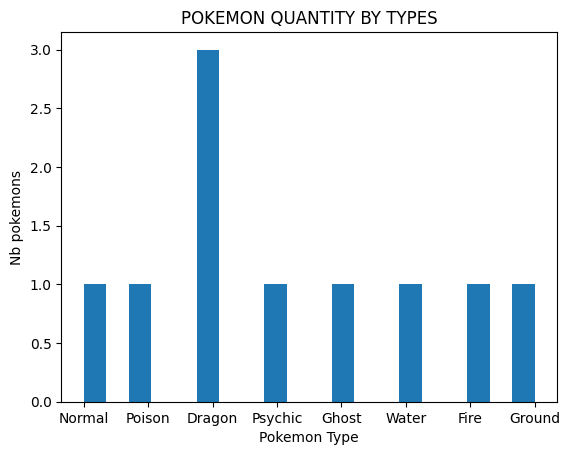

In [117]:
types= [type_ for types in equipe['types'].to_list() for type_ in types]

fig, ax = plt.subplots()
ax.hist(types, bins=20)
ax.set_xlabel('Pokemon Type')
ax.set_ylabel('Nb pokemons')
ax.set_title('Pokemon quantity by Types'.upper())
plt.show()

---
---